Large Steps in Inverse Rendering of Geometry
======================================

This is an example on how to use our method for shape optimization with differentiable rendering. It uses `nvdiffrast` for the differentiable rendering part.

In [1]:
import torch
from tqdm import trange
import os

# 0. Loading the scene

Let's start by loading a scene

In [2]:
from scripts.load_xml import load_scene
import os

In [3]:
# Load the scene
filepath = os.path.join(os.getcwd(), "scenes", "suzanne", "suzanne.xml")
scene_params = load_scene(filepath)

# Load reference shape
v_ref = scene_params["mesh-target"]["vertices"]
n_ref = scene_params["mesh-target"]["normals"]
f_ref = scene_params["mesh-target"]["faces"]

# Load source shape
v = scene_params["mesh-source"]["vertices"]
f = scene_params["mesh-source"]["faces"]

# 1. Rendering references

Then, we need to setup a differentiable rendering pipeline. Here, we use an implementation based on `nvdiffrast`:

In [4]:
from scripts.render import NVDRenderer

We initialize it once, so it loads the camera data, the environment map and precomputes the shading model, using spherical harmonics in this case.

In [5]:
# Initialize the renderer
renderer = NVDRenderer(scene_params, shading=True, boost=3)

Let's render the target shape to use as a reference for the optimization:

In [6]:
ref_imgs = renderer.render(v_ref, n_ref, f_ref)

Let's look at one of these references

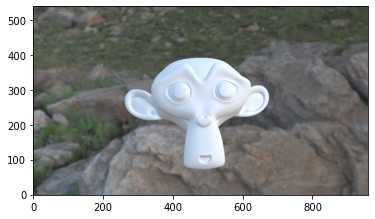

In [7]:
import matplotlib.pyplot as plt
plt.imshow((ref_imgs[5,...,:-1].clip(0,1).pow(1/2.2)).cpu().numpy(), origin='lower')

# 2. Parameterizing

Now it's time to setup the optimization. First, let us import what we need. We need an optimizer, `AdamUniform`, and the functions that allow us to convert back and forth between vertex positions and their parameterization.

In [8]:
from largesteps.parameterize import from_differential, to_differential
from largesteps.geometry import compute_matrix

In [9]:
steps = 1000 # Number of optimization steps
step_size = 3e-2 # Step size
lambda_ = 19 # Hyperparameter lambda of our method, used to compute the matrix (I + lambda_*L)

Now we need to parameterize our shape. 

In [10]:
# Compute the system matrix
M = compute_matrix(v, f, lambda_)

# Parameterize
u = to_differential(M, v)

Let's initialize our optimizer, `AdamUniform`

In [11]:
from largesteps.optimize import AdamUniform

In [12]:
u.requires_grad = True
opt = AdamUniform([u], step_size)

In [13]:
# Dictionary that is returned in the end, contains useful information for debug/analysis
v_steps = torch.zeros((steps+1, *v.shape), device='cuda')
losses = torch.zeros(steps+1, device='cuda')

# 3. Running the optimization

And now we can run our optimization. The only difference with "regular" optimization here is the call to `from_differential` in the loop body, that converts the parameterization to vertex coordinates. The rest of the optimization pipeline is unchanged.

In [14]:
from scripts.geometry import compute_vertex_normals, compute_face_normals
# Optimization loop
for it in trange(steps):

    # Get cartesian coordinates for parameterization
    v = from_differential(M, u, 'Cholesky')

    # Recompute vertex normals
    face_normals = compute_face_normals(v, f)
    n = compute_vertex_normals(v, f, face_normals)

    # Render images
    opt_imgs = renderer.render(v, n, f)

    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()

    # Record optimization state for later processing
    with torch.no_grad():
        losses[it] = loss
        v_steps[it] = v

    # Backpropagate
    opt.zero_grad()
    loss.backward()
    
    # Update parameters
    opt.step() 

100%|██████████| 1000/1000 [00:24<00:00, 40.60it/s]


In [15]:
with torch.no_grad():
    # Render images
    opt_imgs = renderer.render(v, n, f)
    # Compute L1 image loss
    loss = (opt_imgs - ref_imgs).abs().mean()
    losses[-1] = loss
    v_steps[-1] = v

# 4. Visualizing the results

In [16]:
from meshplot import plot
from ipywidgets import interact
import numpy as np

In [17]:
v_numpy = v_steps.cpu().numpy()
f_numpy = f.cpu().numpy()

In [18]:
shading_params = {
    "width": 600, "height": 600,
    "antialias": True,
    "colormap": "viridis",
    "wireframe": True, "wire_width": 0.03, "wire_color": "black"
}

Let's plot the loss:

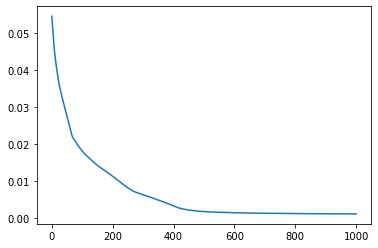

In [19]:
plt.plot(losses.cpu().numpy())

And visualize the mesh across iterations:

In [26]:
@interact(it=(0, steps-1))
def plot_verts(it):
    plot(v_numpy[it], f_numpy, shading=shading_params)

interactive(children=(IntSlider(value=499, description='it', max=999), Output()), _dom_classes=('widget-intera…